In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.cuda.amp import autocast, GradScaler

import torchvision.models as models
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import inception_v3, Inception_V3_Weights

from sklearn.metrics import classification_report, confusion_matrix

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/BreastCancerProject

Mounted at /content/drive
/content/drive/MyDrive/BreastCancerProject


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Load pretrained EfficientNetB0
        self.base_model = models.efficientnet_b0(pretrained=True)

        # Replace the first conv layer to accept 1-channel input
        # self.base_model.features[0][0] = nn.Conv2d(
        #     1, 3, kernel_size=1, stride=1, padding=0  # Conv2D(1, 3, (1, 1)) in Keras
        # )

        # Global Average Pooling after features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Custom dense blocks
        self.fc1 = nn.Linear(1280, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(256, 3)

    def forward(self, x):
        x = self.base_model.features(x)  # EfficientNet features
        x = self.pool(x)                 # Global Average Pooling
        x = torch.flatten(x, 1)

        x = F.leaky_relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.leaky_relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.output_layer(x)
        return x  # Raw logits (apply softmax during evaluation if needed)

In [ ]:
class MyDataset(Dataset):

    label_map = {
        0: 0,  # no tumor
        1: 1,  # benign calcification tumor
        2: 1,  # benign mass tumor
        3: 2,  # malignant calcification tumor
        4: 2,  # malignant mass tumor
    }

    def __init__(self, root_dir, csv_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.meta_data = pd.read_csv(csv_path)

    def __getitem__(self, index):
        row = self.meta_data.iloc[index]
        classification = row['class']
        label = self.label_map[classification]

        image_name = row['id']
        img = Image.open(self.root_dir + image_name + '.png').convert('RGB')
        if self.transform:
            img = self.transform(img)
        # return img, classification
        return img, label

    def __len__(self):
        return len(self.meta_data)

In [ ]:
def compile_and_prepare_model(model):
    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function (for 3-class classification)
    criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay (AdamW)
    initial_learning_rate = 0.0005
    optimizer = optim.AdamW(model.parameters(), lr=initial_learning_rate, weight_decay=0.01)

    # Learning rate scheduler (Exponential decay)
    decay_rate = 0.9
    decay_steps = 1000

    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=3,       # Number of epochs before the first restart
        T_mult=2,     # Multiply T_0 by this factor after each restart
        eta_min=1e-6  # Minimum learning rate
    )

    return model, criterion, optimizer, scheduler, device


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-7, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_state:
                    model.load_state_dict(self.best_model_state)


In [ ]:
from sklearn.metrics import f1_score
# model training with validation and early stopping
def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, early_stopping, num_epochs=60):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        f_1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')

        # Logging
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}, F1: {f_1}")

        torch.save(model.state_dict(), "last_full_model.pth")
        # Callbacks (ReduceLROnPlateau and EarlyStopping)
        scheduler.step(epoch)
        early_stopping(avg_val_loss, model)

        if avg_val_loss <= early_stopping.best_loss:
            torch.save(model.state_dict(), "best_full_model.pth")
            print("Model checkpoint saved.")

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return history


In [ ]:
def evaluate_model(model, test_loader, loss_fn, history, class_names=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    # Initialize variables
    test_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    # No gradients are needed during evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * labels.size(0)

            # Predictions and accuracy calculation
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Average test loss and accuracy
    avg_test_loss = test_loss # / total
    test_accuracy = correct / total

    # Print test results
    print("\nTest Results:")
    print(f"Loss: {avg_test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    if class_names:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    if(history):
        # Plot train and validation loss curves
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
    plt.show()

    return avg_test_loss, test_accuracy, cm, report


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((299, 299)),         # Resize to 299x299 pixels
    transforms.ToTensor(),                 # Convert to tensor
#    transforms.Normalize(
#        mean=[0.485, 0.456, 0.406],        # Normalize using ImageNet statistics
#        std=[0.229, 0.224, 0.225]
#    ),
])
train_dataset0 = MyDataset(root_dir='./training_data_0/', csv_path='./training_data_0/record.csv', transform=data_transforms)
augmented_dataset0 = MyDataset(root_dir='./augmented_data_0/', csv_path='./augmented_data_0/record.csv', transform=data_transforms)
train_dataset1 = MyDataset(root_dir='./training_data_1/', csv_path='./training_data_1/record.csv', transform=data_transforms)
augmented_dataset1 = MyDataset(root_dir='./augmented_data_1/', csv_path='./augmented_data_1/record.csv', transform=data_transforms)
train_dataset2 = MyDataset(root_dir='./training_data_2/', csv_path='./training_data_2/record.csv', transform=data_transforms)
augmented_dataset2 = MyDataset(root_dir='./augmented_data_2/', csv_path='./augmented_data_2/record.csv', transform=data_transforms)
train_dataset3 = MyDataset(root_dir='./training_data_3/', csv_path='./training_data_3/record.csv', transform=data_transforms)
augmented_dataset3 = MyDataset(root_dir='./augmented_data_3/', csv_path='./augmented_data_3/record.csv', transform=data_transforms)
train_dataset4 = MyDataset(root_dir='./training_data_4/', csv_path='./training_data_4/record.csv', transform=data_transforms)
augmented_dataset4 = MyDataset(root_dir='./augmented_data_4/', csv_path='./augmented_data_4/record.csv', transform=data_transforms)

full_dataset = torch.utils.data.ConcatDataset([train_dataset0, augmented_dataset0, train_dataset1, augmented_dataset1,
                                               train_dataset2, augmented_dataset2, train_dataset3, augmented_dataset3,
                                               train_dataset4, augmented_dataset4])
# full_dataset = torch.utils.data.ConcatDataset([train_dataset0, train_dataset1,
#                                                train_dataset2, train_dataset3,
#                                                train_dataset4 ])

In [ ]:
train_loader = DataLoader(
    dataset=full_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=12,
    pin_memory=True
)

In [ ]:
model = CNN()
# model.load_state_dict(torch.load('GOOD_STUFF.pth'))
model, criterion, optimizer, scheduler, device = compile_and_prepare_model(model)

early_stopping = EarlyStopping(patience=10, min_delta=1e-7, restore_best_weights=True)
# calculated via a google sheet
# class_weights = [1.0, 6.053311897, 8.903080904]
class_weights = [1.0,1.0, 1.0]
# class_weights = [1, 46.21576457, 45.77318381, 83.04138749, 53.63780984]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
test_dataset = MyDataset(root_dir='./test/', csv_path='test_labels.csv', transform=data_transforms)
total_size = len(test_dataset)
half_size = total_size // 2
test_set, val_set = random_split(test_dataset, [half_size, total_size - half_size])
test_loader = DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False,
    num_workers=12,
    pin_memory=True
)
val_loader = DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False,
    num_workers=12,
    pin_memory=True
)

In [ ]:
history = train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, early_stopping, num_epochs=60)


Epoch 1/60
Train Loss: 0.3026, Acc: 0.8599 | Val Loss: 0.1132, Acc: 0.9530, F1: 1.0
Model checkpoint saved.

Epoch 2/60
Train Loss: 0.1988, Acc: 0.9155 | Val Loss: 0.1045, Acc: 0.9573, F1: 1.0
Model checkpoint saved.

Epoch 3/60
Train Loss: 0.1184, Acc: 0.9534 | Val Loss: 0.1307, Acc: 0.9538, F1: 0.3333333333333333

Epoch 4/60
Train Loss: 0.0421, Acc: 0.9848 | Val Loss: 0.1241, Acc: 0.9663, F1: 1.0

Epoch 5/60
Train Loss: 0.0923, Acc: 0.9661 | Val Loss: 0.1229, Acc: 0.9645, F1: 1.0

Epoch 6/60
Train Loss: 0.0652, Acc: 0.9763 | Val Loss: 0.1394, Acc: 0.9593, F1: 1.0

Epoch 7/60
Train Loss: 0.0389, Acc: 0.9861 | Val Loss: 0.1479, Acc: 0.9642, F1: 1.0

Epoch 8/60
Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.1693, Acc: 0.9616, F1: 1.0

Epoch 9/60
Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1814, Acc: 0.9667, F1: 1.0

Epoch 10/60
Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1846, Acc: 0.9671, F1: 1.0

Epoch 11/60
Train Loss: 0.0678, Acc: 0.9750 | Val Loss: 0.1442, Acc: 0.9642, F1: 1.0



Test Results:
Loss: 846.1225
Accuracy: 0.9537


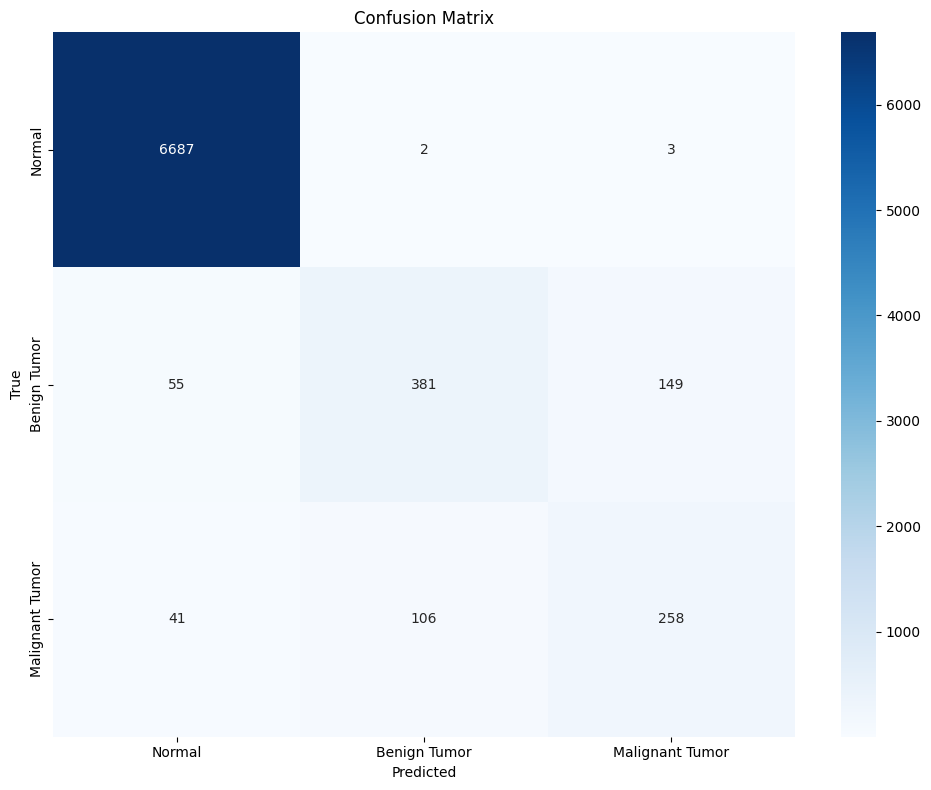


Classification Report:
                 precision    recall  f1-score   support

         Normal     0.9858    0.9993    0.9925      6692
   Benign Tumor     0.7791    0.6513    0.7095       585
Malignant Tumor     0.6293    0.6370    0.6331       405

       accuracy                         0.9537      7682
      macro avg     0.7981    0.7625    0.7784      7682
   weighted avg     0.9513    0.9537    0.9520      7682



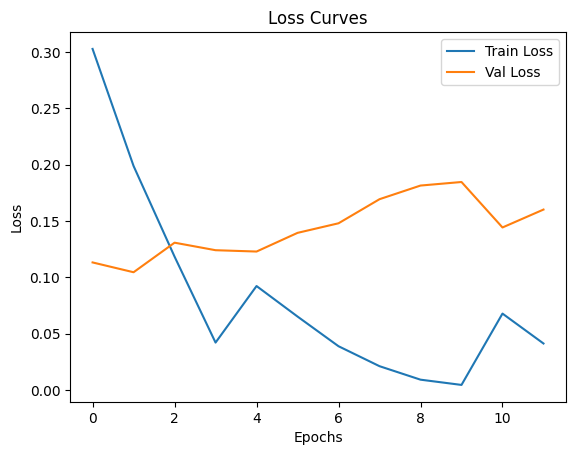

In [ ]:
class_names = ['Normal', 'Benign Tumor', 'Malignant Tumor']
# class_names = [ 'Normal', 'Benign Calcification', 'Benign Mass', 'Malignant Calcification', 'Malignant Mass']
avg_test_loss, test_accuracy, cm, report = evaluate_model(model, test_loader, loss_fn, history, class_names)

In [ ]:
last_model = CNN()
last_model.load_state_dict(torch.load('BREAST_CANCER_BEST.pth'))
avg_test_loss, test_accuracy, cm, report = evaluate_model(last_model, test_loader, loss_fn, history, class_names)
avg_test_loss, test_accuracy, cm, report = evaluate_model(last_model, train_loader, loss_fn, history, class_names)

NameError: name 'CNN' is not defined